# MomentsLD Parameter Analysis

This notebook provides an analysis of MomentsLD optimization results, comparing ground truth parameters with estimated values.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Configuration
EXPERIMENT_NAME = 'split_isolation'  # Change this to your experiment
BASE_PATH = Path(f'/projects/kernlab/akapoor/Infer_Demography/experiments/{EXPERIMENT_NAME}')
SIMULATIONS_PATH = BASE_PATH / 'simulations'
INFERENCES_PATH = BASE_PATH / 'inferences'

print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Simulations path: {SIMULATIONS_PATH}")
print(f"Inferences path: {INFERENCES_PATH}")
print(f"Paths exist: {SIMULATIONS_PATH.exists()}, {INFERENCES_PATH.exists()}")

Experiment: split_isolation
Simulations path: /projects/kernlab/akapoor/Infer_Demography/experiments/split_isolation/simulations
Inferences path: /projects/kernlab/akapoor/Infer_Demography/experiments/split_isolation/inferences
Paths exist: True, True


In [3]:
def load_ground_truth(simulations_path):
    """Load ground truth parameters from simulation directories."""
    gt_data = {}
    
    for sim_dir in sorted(simulations_path.iterdir()):
        if not sim_dir.is_dir():
            continue
        # Accept directories named as numbers (e.g., '0', '1', ...)
        if not sim_dir.name.isdigit():
            continue
        sim_id = sim_dir.name
        param_file = sim_dir / 'sampled_params.pkl'
        if param_file.exists():
            try:
                with open(param_file, 'rb') as f:
                    params = pickle.load(f)
                gt_data[sim_id] = params
            except Exception as e:
                print(f"Error loading {param_file}: {e}")
    
    print(f"Loaded ground truth for {len(gt_data)} simulations")
    return gt_data

def load_coverage_data(simulations_path):
    """Load coverage percentage data from bgs.meta.json files."""
    coverage_data = {}
    
    for sim_dir in sorted(simulations_path.iterdir()):
        if not sim_dir.is_dir():
            continue
        if not sim_dir.name.isdigit():
            continue
        sim_id = sim_dir.name
        meta_file = sim_dir / 'bgs.meta.json'
        if meta_file.exists():
            try:
                with open(meta_file, 'r') as f:
                    meta = json.load(f)
                coverage_data[sim_id] = meta.get('sampled_coverage_percent', None)
            except Exception as e:
                print(f"Error loading {meta_file}: {e}")
                coverage_data[sim_id] = None
        else:
            coverage_data[sim_id] = None
    
    print(f"Loaded coverage data for {len(coverage_data)} simulations")
    valid_coverage = sum(1 for v in coverage_data.values() if v is not None)
    print(f"  {valid_coverage} simulations have coverage data")
    return coverage_data

def load_momentsld_results(inferences_path):
    """Load MomentsLD optimization results."""
    results = {}
    
    # Iterate over sim_* directories in inferences folder
    for sim_dir in sorted(inferences_path.glob('sim_*')):
        if not sim_dir.is_dir():
            continue
            
        sim_id = sim_dir.name.split('_')[1]
        
        # Path to MomentsLD results
        momentsld_dir = sim_dir / 'MomentsLD'
        result_file = momentsld_dir / 'best_fit.pkl'
        
        if result_file.exists():
            try:
                with open(result_file, 'rb') as f:
                    data = pickle.load(f)
                
                results[sim_id] = data
            except Exception as e:
                print(f"Error loading {result_file}: {e}")
    
    print(f"Loaded MomentsLD results for {len(results)} simulations")
    return results

def extract_parameters(moments_data):
    """Extract parameters and likelihood from moments results."""
    params = {}
    likelihood = None
    
    # Handle different result file formats
    if isinstance(moments_data, dict):
        # Look for parameters
        if 'best_params' in moments_data:
            if isinstance(moments_data['best_params'], dict):
                params = moments_data['best_params']
            elif 'param_order' in moments_data:
                order = moments_data['param_order']
                values = moments_data['best_params']
                params = dict(zip(order, values))
            else:
                # Fallback if param_order is missing but we have a list
                # You might need to know the order manually if it's not in the file
                pass
        
        # Look for likelihood
        for key in ['best_ll', 'log_likelihood', 'll']:
            if key in moments_data:
                val = moments_data[key]
                likelihood = val[0] if isinstance(val, (list, tuple)) else val
                break
    
    if likelihood is not None:
        params['log_likelihood'] = float(likelihood)
    
    return params

print("Helper functions defined!")

Helper functions defined!


In [4]:
# Load the data
print("Loading ground truth parameters...")
ground_truth = load_ground_truth(SIMULATIONS_PATH)

print("\nLoading coverage data...")
coverage_data = load_coverage_data(SIMULATIONS_PATH)

print("\nLoading MomentsLD results...")
momentsld_results = load_momentsld_results(INFERENCES_PATH)

# Show example data
if ground_truth:
    first_sim = list(ground_truth.keys())[0]
    print(f"\nExample ground truth parameters (sim {first_sim}):")
    for key, value in ground_truth[first_sim].items():
        print(f"  {key}: {value}")

if coverage_data:
    print(f"\nExample coverage data:")
    for i, (sim_id, coverage) in enumerate(list(coverage_data.items())[:5]):
        print(f"  Sim {sim_id}: {coverage}% coverage" if coverage else f"  Sim {sim_id}: No coverage data")

if momentsld_results:
    first_sim = list(momentsld_results.keys())[0]
    example_params = extract_parameters(momentsld_results[first_sim])
    print(f"\nExample estimated parameters (sim {first_sim}):")
    for key, value in example_params.items():
        print(f"  {key}: {value}")

Loading ground truth parameters...


Loaded ground truth for 5000 simulations

Loading coverage data...
Loaded coverage data for 5000 simulations
  4998 simulations have coverage data

Loading MomentsLD results...
Loaded MomentsLD results for 441 simulations

Example ground truth parameters (sim 0):
  N_anc: 26129.93062695142
  N_YRI: 23410.977292794298
  N_CEU: 23196.952511966996
  m_YRI_CEU: 1.2137055339789411e-05
  T_split: 4025.1437323318987

Example coverage data:
  Sim 0: 78.21471591486734% coverage
  Sim 1: 53.674979351797205% coverage
  Sim 10: 26.422950029758432% coverage
  Sim 100: 77.44296144556104% coverage
  Sim 1000: 13.84586431921381% coverage

Example estimated parameters (sim 10):
  N_anc: 2974.4888981831978
  N_YRI: 3664.9347580242766
  N_CEU: 17917.27578604502
  m_YRI_CEU: 4.737177766925829e-05
  T_split: 12687.842552047427


In [5]:
# Create comparison dataframe
comparison_data = []

for sim_id in ground_truth.keys():
    if sim_id not in momentsld_results:
        continue
        
    gt_params = ground_truth[sim_id]
    coverage = coverage_data.get(sim_id, None)
    
    est_data = momentsld_results[sim_id]
    est_params = extract_parameters(est_data)
    
    # Find common parameters
    common_params = set(gt_params.keys()) & set(est_params.keys())
    common_params.discard('log_likelihood')
    
    for param in common_params:
        gt_val = gt_params[param]
        est_val = est_params[param]
        
        comparison_data.append({
            'simulation': sim_id,
            'parameter': param,
            'ground_truth': gt_val,
            'estimated': est_val,
            'absolute_error': est_val - gt_val,
            'relative_error': (est_val - gt_val) / gt_val if gt_val != 0 else np.nan,
            'coverage_percent': coverage
        })
    
    # Add likelihood separately
    if 'log_likelihood' in est_params:
        comparison_data.append({
            'simulation': sim_id,
            'parameter': 'log_likelihood',
            'ground_truth': np.nan,
            'estimated': est_params['log_likelihood'],
            'absolute_error': np.nan,
            'relative_error': np.nan,
            'coverage_percent': coverage
        })

df = pd.DataFrame(comparison_data)
print(f"Created comparison dataframe with {len(df)} rows")
if not df.empty:
    print(f"Parameters: {sorted(df['parameter'].unique())}")
    print(f"Simulations: {len(df['simulation'].unique())}")

    # Check coverage data distribution
    coverage_stats = df['coverage_percent'].describe()
    print(f"\nCoverage percentage statistics:")
    print(coverage_stats)

    # Show first few rows
    display(df.head(10))
else:
    print("No matching data found between ground truth and MomentsLD results.")

Created comparison dataframe with 2205 rows
Parameters: ['N_CEU', 'N_YRI', 'N_anc', 'T_split', 'm_YRI_CEU']
Simulations: 441

Coverage percentage statistics:
count    2205.000000
mean       40.554724
std        26.215811
min         1.156901
25%        15.636657
50%        39.199842
75%        62.946404
max        89.638353
Name: coverage_percent, dtype: float64


,simulation,parameter,ground_truth,estimated,absolute_error,relative_error,coverage_percent
0,10,T_split,15183.947663,12687.842552,-2496.105111,-0.164391,26.422950
1,10,N_anc,3825.120209,2974.488898,-850.631311,-0.222380,26.422950
2,10,m_YRI_CEU,0.000042,0.000047,0.000005,0.120822,26.422950
3,10,N_YRI,4295.067094,3664.934758,-630.132336,-0.146711,26.422950
4,10,N_CEU,24347.520254,17917.275786,-6430.244468,-0.264103,26.422950
5,100,T_split,12253.198652,15246.153095,2992.954443,0.244259,77.442961
6,100,N_anc,7335.688370,4065.668790,-3270.019580,-0.445769,77.442961
7,100,m_YRI_CEU,0.000042,0.000041,-0.000002,-0.036262,77.442961
8,100,N_YRI,7736.121127,4833.012671,-2903.108456,-0.375267,77.442961
9,100,N_CEU,20535.349991,11216.470512,-9318.879479,-0.453797,77.442961


Plotting 5 parameters: ['T_split', 'N_anc', 'm_YRI_CEU', 'N_YRI', 'N_CEU']


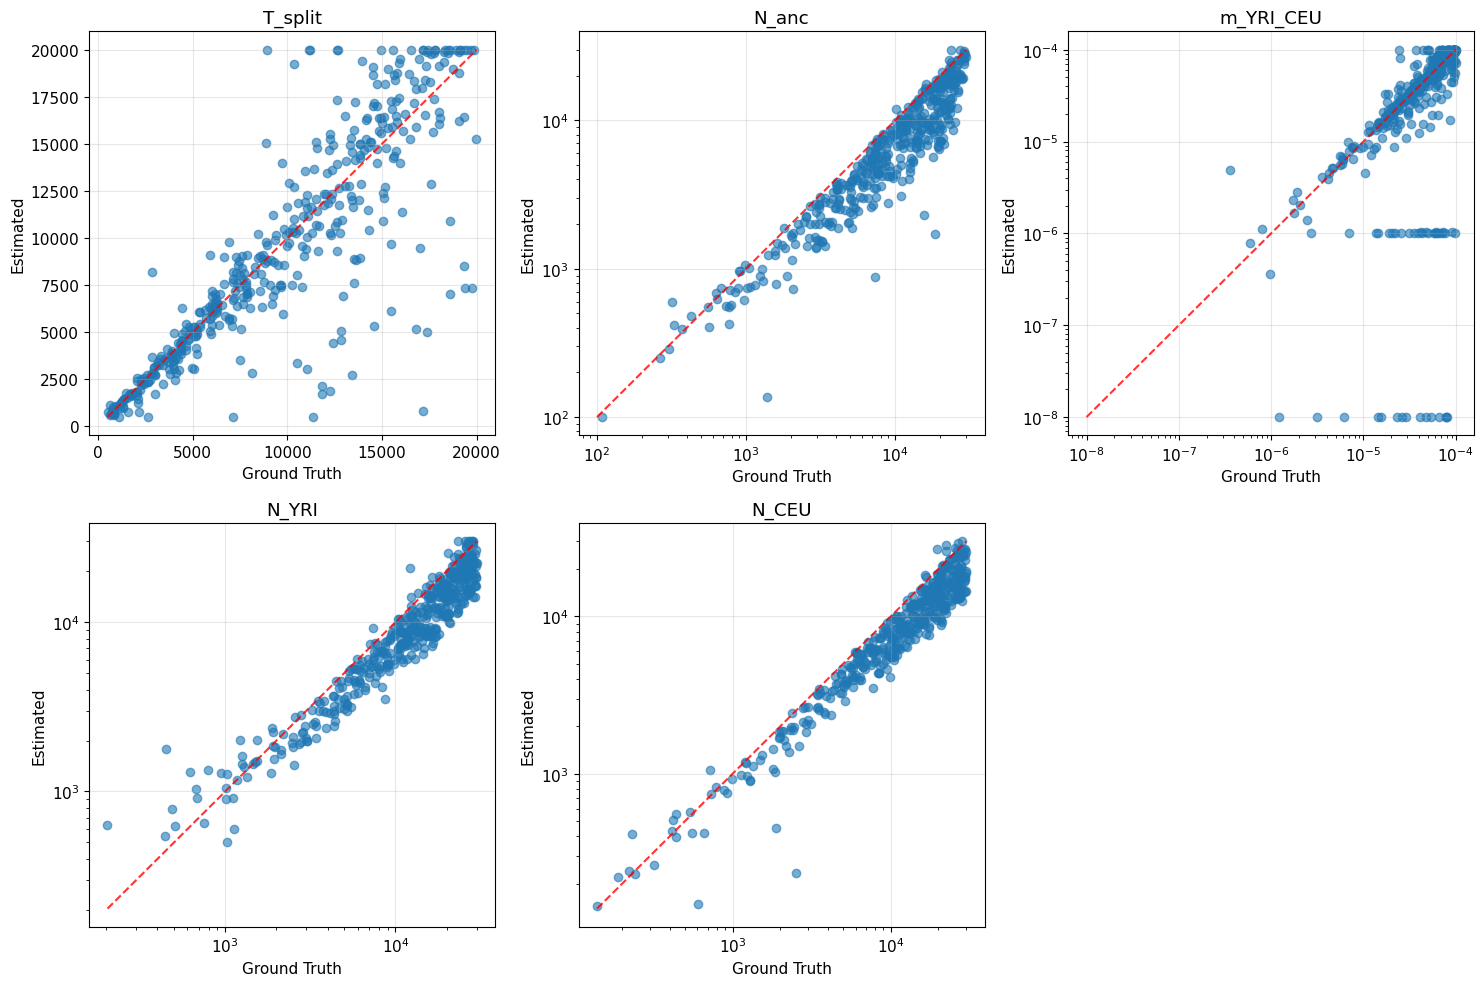

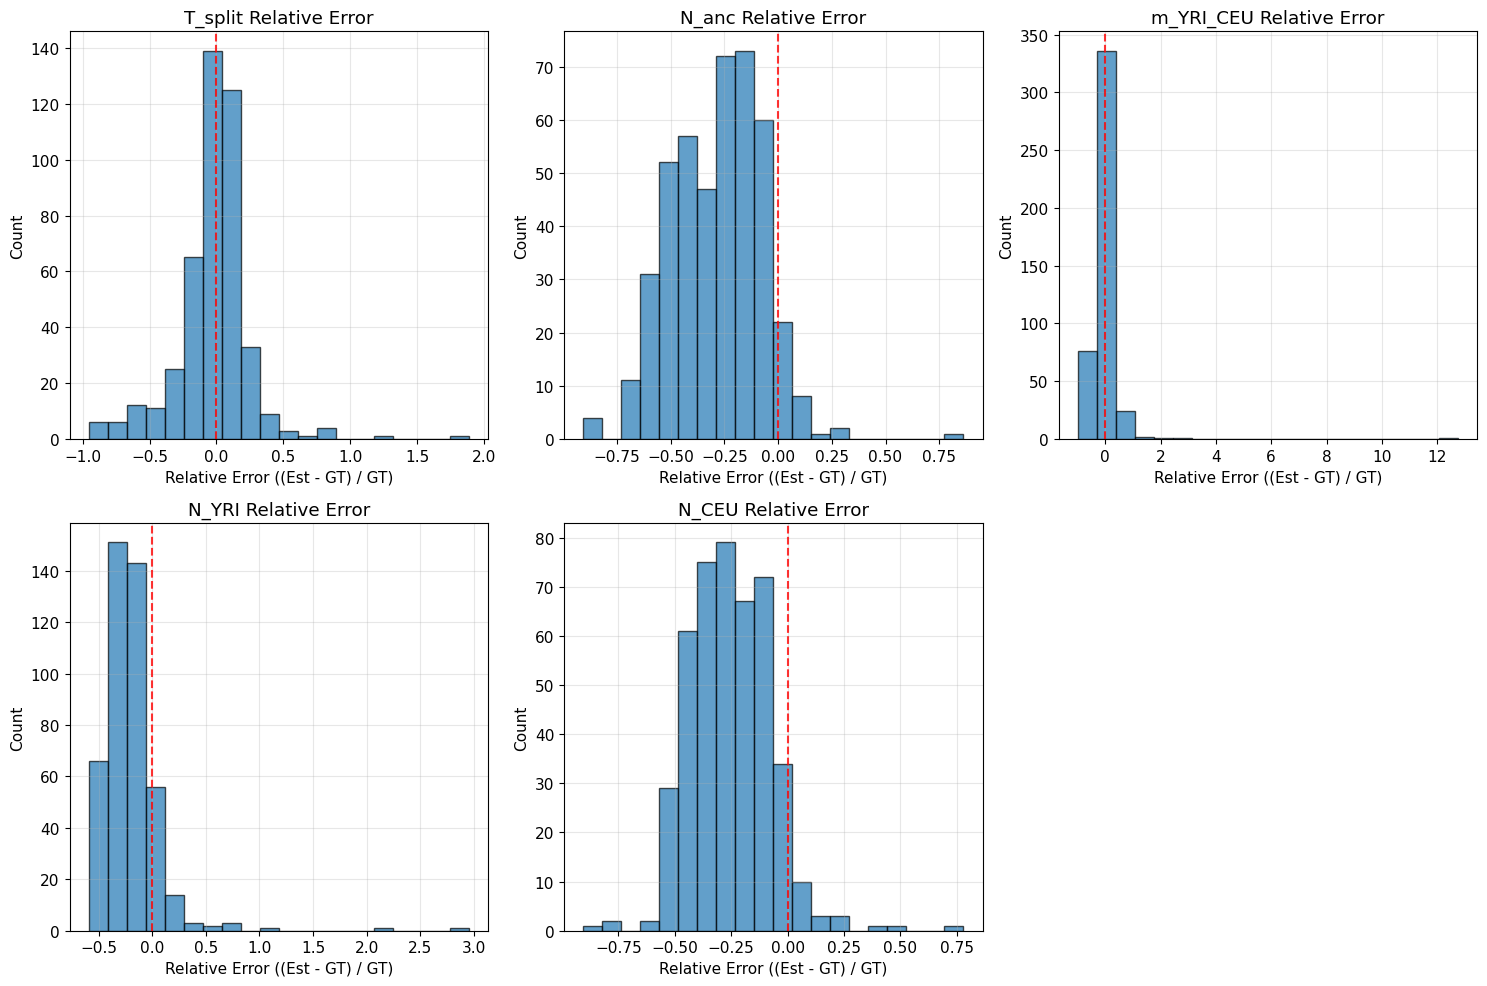

In [6]:
# Plotting
if not df.empty:
    parameters = [p for p in df['parameter'].unique() if p != 'log_likelihood']
    print(f"Plotting {len(parameters)} parameters: {parameters}")
    
    # 1. Scatter plots: Ground Truth vs Estimated
    n_cols = 3
    n_rows = (len(parameters) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    axes = axes.flatten()
    
    for i, param in enumerate(parameters):
        ax = axes[i]
        subset = df[df['parameter'] == param]
        
        # Scatter plot
        ax.scatter(subset['ground_truth'], subset['estimated'], alpha=0.6)
        
        # 1:1 line
        min_val = min(subset['ground_truth'].min(), subset['estimated'].min())
        max_val = max(subset['ground_truth'].max(), subset['estimated'].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
        
        ax.set_title(f'{param}')
        ax.set_xlabel('Ground Truth')
        ax.set_ylabel('Estimated')
        ax.grid(True, alpha=0.3)
        
        # Log scale if range is large
        if max_val / (min_val + 1e-9) > 100:
            ax.set_xscale('log')
            ax.set_yscale('log')
            
    # Hide empty subplots
    for i in range(len(parameters), len(axes)):
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()
    
    # 2. Relative Error Distributions
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    axes = axes.flatten()
    
    for i, param in enumerate(parameters):
        ax = axes[i]
        subset = df[df['parameter'] == param]
        
        # Histogram of relative error
        errors = subset['relative_error'].dropna()
        ax.hist(errors, bins=20, alpha=0.7, edgecolor='black')
        
        ax.axvline(0, color='r', linestyle='--', alpha=0.8)
        
        ax.set_title(f'{param} Relative Error')
        ax.set_xlabel('Relative Error ((Est - GT) / GT)')
        ax.set_ylabel('Count')
        ax.grid(True, alpha=0.3)
        
    # Hide empty subplots
    for i in range(len(parameters), len(axes)):
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()

Plotting 5 parameters: ['T_split', 'N_anc', 'm_YRI_CEU', 'N_YRI', 'N_CEU']


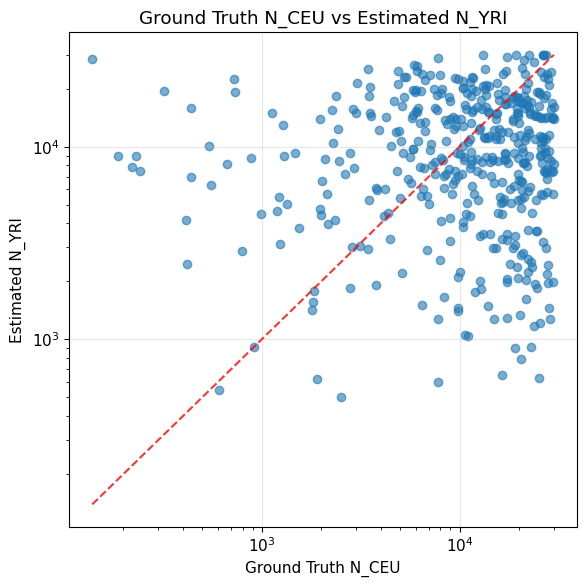

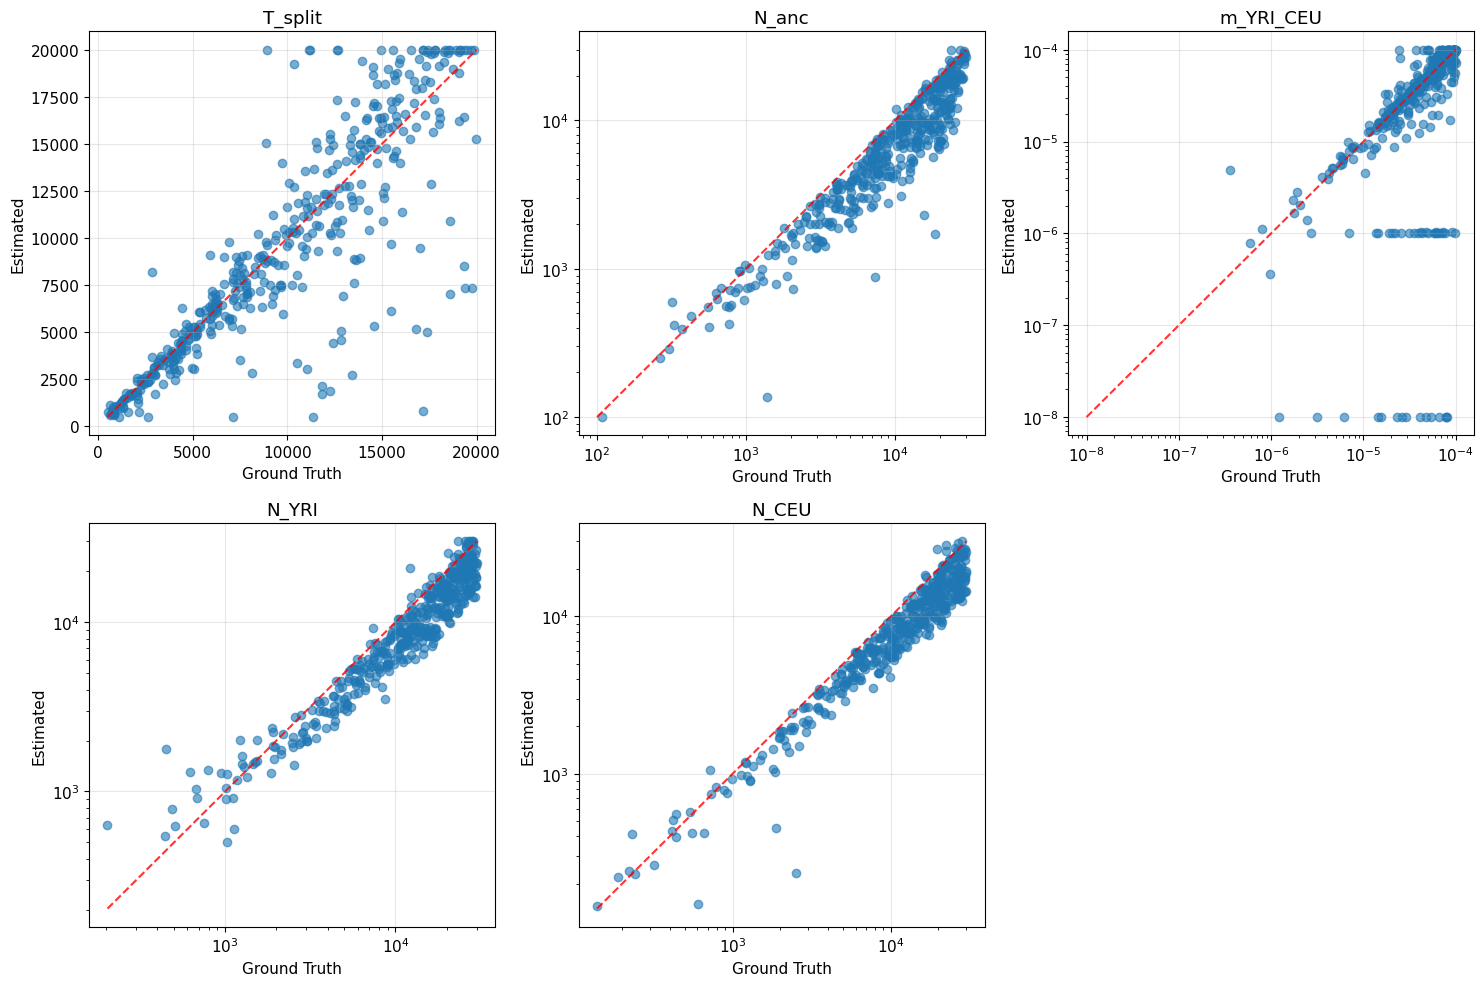

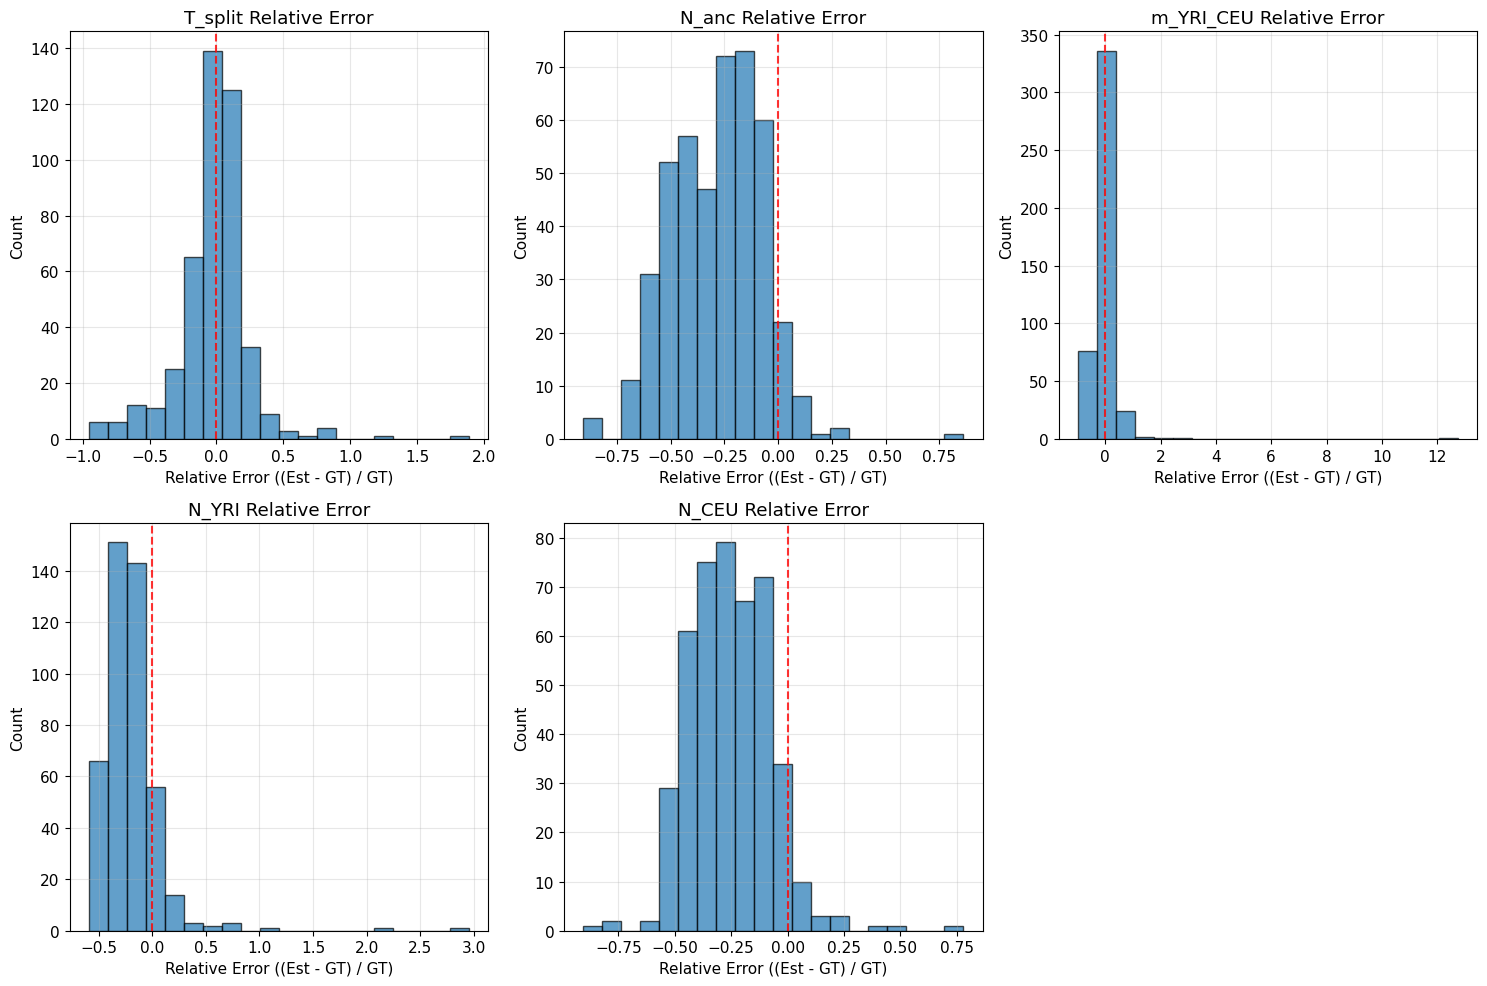

In [7]:
# Plotting
if not df.empty:
    parameters = [p for p in df['parameter'].unique() if p != 'log_likelihood']
    print(f"Plotting {len(parameters)} parameters: {parameters}")
    
    # 0. SPECIAL CHECK: GT N_CEU vs EST N_YRI -----------------------------
    # Pivot to wide form: index = simulation, columns = parameter
    gt_wide = df.pivot(index='simulation', columns='parameter', values='ground_truth')
    est_wide = df.pivot(index='simulation', columns='parameter', values='estimated')

    if ('N_CEU' in gt_wide.columns) and ('N_YRI' in est_wide.columns):
        x = gt_wide['N_CEU']          # ground truth N_CEU
        y = est_wide['N_YRI']         # estimated N_YRI

        plt.figure(figsize=(6, 6))
        plt.scatter(x, y, alpha=0.6)

        # 1:1 line
        min_val = min(x.min(), y.min())
        max_val = max(x.max(), y.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)

        plt.xlabel('Ground Truth N_CEU')
        plt.ylabel('Estimated N_YRI')
        plt.title('Ground Truth N_CEU vs Estimated N_YRI')
        plt.grid(True, alpha=0.3)

        # Optional: log scale if huge dynamic range
        if max_val / (min_val + 1e-9) > 100:
            plt.xscale('log')
            plt.yscale('log')

        plt.tight_layout()
        plt.show()
    else:
        print("Could not find N_CEU or N_YRI columns for cross-plot; skipping.")
    # ---------------------------------------------------------------------

    # 1. Scatter plots: Ground Truth vs Estimated (per parameter)
    n_cols = 3
    n_rows = (len(parameters) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    axes = axes.flatten()
    
    for i, param in enumerate(parameters):
        ax = axes[i]
        subset = df[df['parameter'] == param]
        
        # Scatter plot
        ax.scatter(subset['ground_truth'], subset['estimated'], alpha=0.6)
        
        # 1:1 line
        min_val = min(subset['ground_truth'].min(), subset['estimated'].min())
        max_val = max(subset['ground_truth'].max(), subset['estimated'].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
        
        ax.set_title(f'{param}')
        ax.set_xlabel('Ground Truth')
        ax.set_ylabel('Estimated')
        ax.grid(True, alpha=0.3)
        
        # Log scale if range is large
        if max_val / (min_val + 1e-9) > 100:
            ax.set_xscale('log')
            ax.set_yscale('log')
            
    # Hide empty subplots
    for i in range(len(parameters), len(axes)):
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()
    
    # 2. Relative Error Distributions
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    axes = axes.flatten()
    
    for i, param in enumerate(parameters):
        ax = axes[i]
        subset = df[df['parameter'] == param]
        
        # Histogram of relative error
        errors = subset['relative_error'].dropna()
        ax.hist(errors, bins=20, alpha=0.7, edgecolor='black')
        
        ax.axvline(0, color='r', linestyle='--', alpha=0.8)
        
        ax.set_title(f'{param} Relative Error')
        ax.set_xlabel('Relative Error ((Est - GT) / GT)')
        ax.set_ylabel('Count')
        ax.grid(True, alpha=0.3)
        
    # Hide empty subplots
    for i in range(len(parameters), len(axes)):
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()
